# Лабораторная работа №2. Преобразование сферы в модель.

Задание:
Преобразовать сферу в свою модель.

### Импорт библиотек

In [11]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from mesh_to_sdf import sample_sdf_near_surface
import pyrender

import torch

from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from tqdm import tqdm_notebook
from celluloid import Camera
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj, save_obj
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

from mpl_toolkits.mplot3d import Axes3D
from pytorch3d.vis.plotly_vis import plot_scene

In [12]:
# If you have got a CUDA device, you can use GPU mode
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  device = torch.device('cpu')

### Импорт модели

In [16]:
trg_obj = 'audi/audi_r8.obj'

verts, faces, aux = load_obj(trg_obj)

faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

### Сфера

In [17]:
sphere_mesh = ico_sphere(4, device)
verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]

### Задаем оптимизируемые параметры и сам оптимизатор

In [18]:
deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

### Устанавливаем параметры для процесса оптимизации

In [19]:
# Number of optimization steps
Niter = 5001
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 500

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

### Визуализация

In [20]:
def plot_res(mesh, title=""):
    fig = plot_scene({
        title: {
            "mesh": mesh
        }
    })
    fig.show()

### В цикле будем делать градиентный спуск по функции потерь, представляющей из себя взвешенную сумму функций ошибок и регуляризаторов

In [21]:
loop = tqdm_notebook(range(Niter))

%matplotlib inline
fig = plt.figure()
camera = Camera(fig)


for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_mesh = sphere_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)
    

    # Plot mesh
    if i % plot_period == 0:
        plot_res(new_mesh, title="iter: %d" % i)

        
    # Optimization step
    loss.backward()
    optimizer.step()

<ipython-input-21-bd93d82a2f37>:1: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



<Figure size 432x288 with 0 Axes>

### Визуализируем изменение функций потерь и регуляризаторов в процессе оптимизации

Text(0.5, 1.0, 'Loss vs iterations')

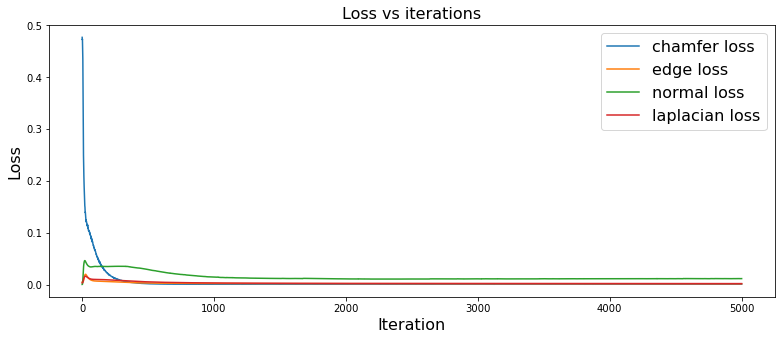

In [22]:
# Losses evaluation
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")